In [1]:
%matplotlib widget
import itertools
import numpy as np
from functools import partial
from oscar import (
    CustomExecutor,
    QiskitOptimizer,
    plot_2d_landscape,
    ScikitQuantOptimizer,
    # PDFOOptimizer,
    InterpolatedLandscapeExecutor,
    NLoptOptimizer,
    HyperparameterTuner,
    HyperparameterGrid,
    HyperparameterSet
)
from qiskit.algorithms.optimizers import COBYLA
from math import pi
from run_landscape import evaluate_energy
import matplotlib.pyplot as plt
import pickle


sample_seed = 42
rng = np.random.default_rng(sample_seed)

def sample_energy(params, landscape, landscape_std, shots):
    energy = landscape.interpolator(params)[0]
    if shots is None:
        return energy
    energy_std = landscape_std.interpolator(params)[0] / np.sqrt(shots)
    return rng.normal(energy, energy_std)

def calculate_ar(po_problem, energy):
    min_constrained = po_problem["feasible_min"]
    max_constrained = po_problem["feasible_max"]
    return (energy - max_constrained) / (min_constrained - max_constrained)

In [5]:
depth_pool = [1]
qubit_pool = [10]
seed_pool = list(range(1))
resolutions = [128, 32]
bounds = [(-2.2, -0.6), (0.9, 1.3)]
# shot_pool = range(100, 1601, 500)
# maxfev_pool = list(range(5, 100))
maxfev_pool = list(range(4, 21)) #+ [25, 33, 50, 66, 100, 150, 200]
# maxfev_pool = [2000]
initial_point = [-1.24727193, 1.04931211]
# initial_point = [-2.2, 0.9]
reps = 10
# method_pool = ["uobyqa", "newuoa", "bobyqa", "lincoa", "cobyla"]  # , "imfil", "snobfit"]
# method_pool = ["COBYLA", "POWELL", "L_BFGS_B", "SLSQP", "SPSA", "NELDER_MEAD", "BOBYQA", "IMFIL"]
method_pool = ["COBYLA"]
budget = 5000
# rhobeg_pool = np.linspace(0.1, 0.3, 11).tolist()
# rhobeg_pool = np.linspace(0.001, 0.01, 10).tolist() + np.linspace(0.02, 0.2, 19).tolist()
rhobeg_pool = [0.2]
# xtol_pool = np.linspace(0.01, 0.1, 20).tolist()
xtol_pool = [0.045]
scaling = 2

configs = []
for method, maxfev, rhobeg, xtol in itertools.product(method_pool, maxfev_pool, rhobeg_pool, xtol_pool):
    shots = budget // maxfev
    if method in ["snobfit", "imfil"] and rhobeg != rhobeg_pool[0]:
        continue
    # elif method == "":
    configs.append((method, maxfev, shots, rhobeg, xtol))
mean_ar = np.zeros(len(configs), dtype=float)
solved_ratio = np.zeros(len(configs), dtype=float)
num_instances = len(depth_pool) * len(qubit_pool) * len(seed_pool)
print(f"Trying {len(configs)} configs on {num_instances} instances for {reps} trials each...")

grid_best_ar, initial_point_ar = [], []
for p, n, seed in itertools.product(depth_pool, qubit_pool, seed_pool):
    print(f"Landscape {p=} {n=} {seed=}")
    filename = f"data/landscapes/{p=}/{n=}/{p=}-{n=}-{seed=}-{bounds}-{resolutions}"
    landscape = np.load(filename + ".pckl", allow_pickle=True)
    print("Grid minima: ", landscape.optimal_params().flatten(), landscape.optimal_value())
    landscape_std = np.load(filename + "-std.pckl", allow_pickle=True)
    po_problem = pickle.load(
        open(f"data/random/po_problem_rule_{n}_{n//2}_0.5_seed{seed}.pckl", "rb")
    )
    true_executor = InterpolatedLandscapeExecutor(landscape)
    grid_best_ar.append(calculate_ar(po_problem, landscape.optimal_value()))
    initial_point_ar.append(calculate_ar(po_problem, true_executor.run(initial_point)))

    energies, solved_counts = [], []
    for method, maxfev, shots, rhobeg, xtol in configs:
        energy = 0
        for _ in range(reps):
            itpl_executor = CustomExecutor(
                partial(
                    sample_energy,
                    landscape=landscape,
                    landscape_std=landscape_std,
                    shots=shots,
                )
            )
            if method == "RECOBYLA":
                from restarting_cobyla import RECOBYLA

                trace, result = RECOBYLA().run(
                    CustomExecutor(
                        partial(
                            sample_energy,
                            landscape=landscape,
                            landscape_std=landscape_std,
                        )
                    ),
                    initial_point,
                    budget,
                    bounds,
                    rhobeg,
                    xtol,
                    shots,
                    scaling,
                    p,
                )
            elif method in ["COBYLA"]:
                from nlopt import opt, LN_COBYLA

                optimizer = opt(LN_COBYLA, 2 * p)
                optimizer.set_lower_bounds(np.array(bounds).T[0])
                optimizer.set_upper_bounds(np.array(bounds).T[1])
                optimizer.set_initial_step(rhobeg)
                # optimizer.set_xtol_abs(xtol)
                optimizer.set_maxeval(maxfev)
                trace, result = NLoptOptimizer(optimizer).run(
                    itpl_executor, initial_point=initial_point
                )
            # elif method in ["uobyqa", "newuoa"]:
            #     trace, _ = PDFOOptimizer(method, maxfev).run(
            #         itpl_executor, initial_point=initial_point, rhobeg=rhobeg
            #     )
            # elif method in ["bobyqa", "lincoa", "cobyla"]:
            #     trace, _ = PDFOOptimizer(method, maxfev).run(
            #         itpl_executor, initial_point=initial_point, bounds=bounds, rhobeg=rhobeg
            #     )
            else:
                from qiskit.algorithms import optimizers as qiskit_optimizers

                trace, _ = QiskitOptimizer(
                    getattr(qiskit_optimizers, method)(maxiter=maxfev, rhobeg=rhobeg)
                ).run(itpl_executor, initial_point=initial_point, bounds=bounds)
            # plot_2d_landscape(landscape, trace, figure=plt.figure(figsize=(12, 3)))
            energy += true_executor.run(trace.optimal_params)
        print(method, maxfev, shots, trace.num_fun_evals, rhobeg, trace.num_iters)
        energies.append(energy / reps)
    ar = calculate_ar(po_problem, np.array(energies))
    mean_ar = mean_ar + ar
    solved_counts = (grid_best_ar[-1] - ar) <= grid_best_ar[-1] * 0.01
    solved_ratio += np.array(solved_counts, dtype=float)

mean_ar /= num_instances
solved_ratio /= num_instances

Trying 17 configs on 1 instances for 10 trials each...
Landscape p=1 n=10 seed=0
Grid minima:  [-1.4125  1.05  ] 0.06538166232906727
COBYLA 4 1250 4 0.2 4
COBYLA 5 1000 5 0.2 5
COBYLA 6 833 6 0.2 6
COBYLA 7 714 7 0.2 7
COBYLA 8 625 8 0.2 8
COBYLA 9 555 9 0.2 9
COBYLA 10 500 10 0.2 10
COBYLA 11 454 11 0.2 11
COBYLA 12 416 12 0.2 12
COBYLA 13 384 13 0.2 13
COBYLA 14 357 14 0.2 14
COBYLA 15 333 15 0.2 15
COBYLA 16 312 16 0.2 16
COBYLA 17 294 17 0.2 17
COBYLA 18 277 18 0.2 18
COBYLA 19 263 19 0.2 19
COBYLA 20 250 20 0.2 20


In [6]:
print("Grid best AR: ", np.mean(grid_best_ar))
print("Initial point AR: ", np.mean(initial_point_ar))
for i in np.argsort(mean_ar)[-1:-100:-1]:
    print(mean_ar[i], configs[i])
print()
for i in np.argsort(solved_ratio)[-1:-100:-1]:
    print(solved_ratio[i], configs[i])

Grid best AR:  0.8474302789734415
Initial point AR:  0.8425873522919056
0.8422757295268666 ('COBYLA', 18, 277, 0.2, 0.045)
0.8422121987507754 ('COBYLA', 4, 1250, 0.2, 0.045)
0.8414099376074433 ('COBYLA', 19, 263, 0.2, 0.045)
0.8409737886192044 ('COBYLA', 10, 500, 0.2, 0.045)
0.8393348471299913 ('COBYLA', 5, 1000, 0.2, 0.045)
0.8380989945368956 ('COBYLA', 16, 312, 0.2, 0.045)
0.8380902612948152 ('COBYLA', 15, 333, 0.2, 0.045)
0.8377932902481573 ('COBYLA', 12, 416, 0.2, 0.045)
0.8365446062651273 ('COBYLA', 13, 384, 0.2, 0.045)
0.8362019901424903 ('COBYLA', 14, 357, 0.2, 0.045)
0.8359359843294111 ('COBYLA', 8, 625, 0.2, 0.045)
0.8357280717411785 ('COBYLA', 20, 250, 0.2, 0.045)
0.8353323955679413 ('COBYLA', 7, 714, 0.2, 0.045)
0.834872375120481 ('COBYLA', 9, 555, 0.2, 0.045)
0.834262520585096 ('COBYLA', 11, 454, 0.2, 0.045)
0.8313828110333326 ('COBYLA', 17, 294, 0.2, 0.045)
0.8312180168889896 ('COBYLA', 6, 833, 0.2, 0.045)

1.0 ('COBYLA', 4, 1250, 0.2, 0.045)
1.0 ('COBYLA', 10, 500, 0.2, 0

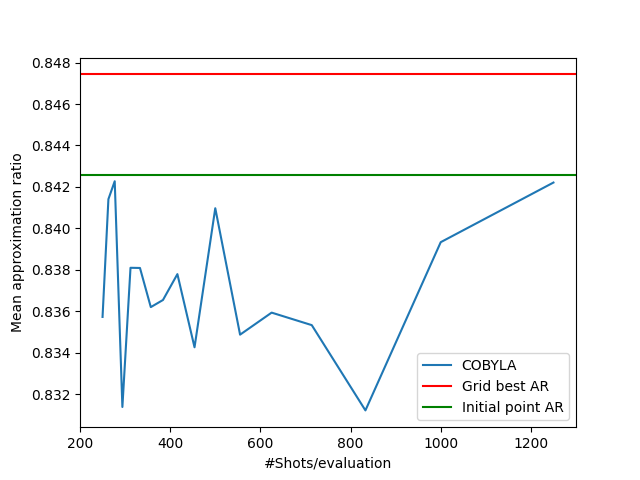

In [7]:
plt.figure()
# ys = np.max(mean_ar.reshape(1, -1, len(xtol_pool), axis=2)
ys = mean_ar.reshape(len(method_pool), -1)
for y, label in zip(ys, method_pool):
    plt.plot(budget // np.array(maxfev_pool), y, label=f"{label}")
# plt.xlabel("Max function evaluations")
plt.xlabel("#Shots/evaluation")
plt.ylabel("Mean approximation ratio")
# plt.ylim(0.71, 0.74)
# plt.xlim(0, 40)
plt.axhline(np.mean(grid_best_ar), label="Grid best AR", color='r')
plt.axhline(np.mean(initial_point_ar), label="Initial point AR", color='g')
plt.legend()

Total time: 0.008544921875
Optimal parameters reported:  [-1.3780828   0.94243093]
Optimal value reported:  0.04059281076799518
Number of evaluations:  20


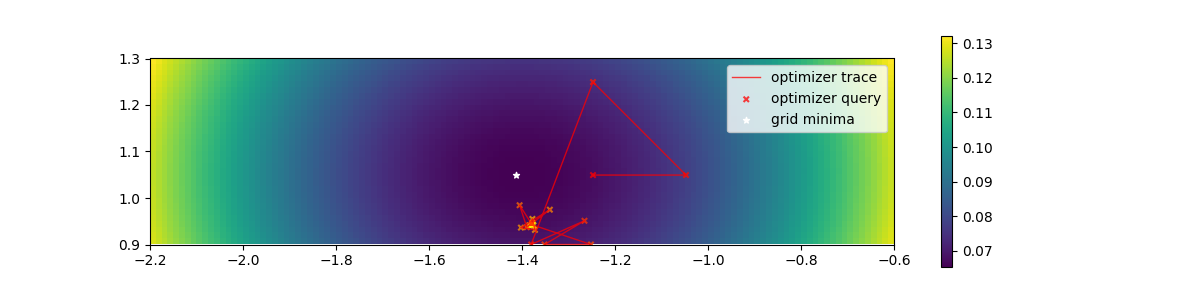

In [8]:
from oscar import plot_2d_landscape

# plot_2d_landscape(landscape_std, trace, figure=plt.figure(figsize=(12, 3)))
plot_2d_landscape(landscape, trace, figure=plt.figure(figsize=(12, 3)), show=False)
# plt.xlim(-1.4, -1)
trace.print_result()

In [ ]:
pickle.dump(
    {
        "mean_ar": mean_ar,
        "solved_ratio": solved_ratio,
        "configs": configs,
        "method_pool": method_pool,
        "maxfev_pool": maxfev_pool,
        "rhobeg_pool": rhobeg_pool,
        "depth_pool": depth_pool,
        "qubit_pool": qubit_pool,
        "seed_pool": seed_pool,
        "resolutions": resolutions,
        "bounds": bounds,
        "initial_point": initial_point,
        "reps": reps,
        "budget": budget,
    },
    open(
        f"data/configs/m{len(method_pool)}-f{len(maxfev_pool)}-r{len(rhobeg_pool)}-d{len(depth_pool)}-q{len(qubit_pool)}-s{len(seed_pool)}",
        "wb",
    ),
)

In [2]:
depth_pool = [1]
qubit_pool = [14, 16, 18]
seed_pool = list(range(10))
resolutions = [128, 32]
bounds = [(-2.2, -0.6), (0.9, 1.3)]
shots_pool = range(100, 2001, 100)
# maxfev_pool = list(range(5, 100))
# maxfev_pool = list(range(4, 21)) + [25, 33, 50, 66, 100]
maxfev_pool = list(range(4, 101))
initial_point = [-1.24727193, 1.04931211]
# initial_point = [-2.2, 0.9]
reps = 5
# method_pool = ["uobyqa", "newuoa", "bobyqa", "lincoa", "cobyla"]  # , "imfil", "snobfit"]
# method_pool = ["COBYLA", "POWELL", "L_BFGS_B", "SLSQP", "SPSA", "NELDER_MEAD", "BOBYQA", "IMFIL"]
method_pool = ["RECOBYLA"]
# budget = 10000
# rhobeg_pool = np.linspace(0.1, 0.3, 6).tolist()
rhobeg_pool = [0.2]
# xtol_pool = np.linspace(0, 0.1, 6).tolist()
xtol_pool = [0.045]
scaling = 2

configs = []
for method, shots, rhobeg, xtol in itertools.product(method_pool, shots_pool, rhobeg_pool, xtol_pool):
    configs.append((method, shots, rhobeg, xtol))
mean_ar = np.zeros(len(configs) * len(maxfev_pool), dtype=float)
solved_ratio = np.zeros(len(configs) * len(maxfev_pool), dtype=float)
num_instances = len(depth_pool) * len(qubit_pool) * len(seed_pool)
print(f"Trying {len(configs)} configs on {num_instances} instances for {reps} trials each...")

grid_best_ar, initial_point_ar = [], []
for p, n, seed in itertools.product(depth_pool, qubit_pool, seed_pool):
    print(f"Landscape {p=} {n=} {seed=}")
    filename = f"data/landscapes/{p=}/{n=}/{p=}-{n=}-{seed=}-{bounds}-{resolutions}"
    landscape = np.load(filename + ".pckl", allow_pickle=True)
    print("Grid minima: ", landscape.optimal_params().flatten(), landscape.optimal_value())
    landscape_std = np.load(filename + "-std.pckl", allow_pickle=True)
    po_problem = pickle.load(
        open(f"data/random/po_problem_rule_{n}_{n//2}_0.5_seed{seed}.pckl", "rb")
    )
    true_executor = InterpolatedLandscapeExecutor(landscape)
    grid_best_ar.append(calculate_ar(po_problem, landscape.optimal_value()))
    initial_point_ar.append(calculate_ar(po_problem, true_executor.run(initial_point)))

    for _ in range(reps):
        energies, solved_counts = [], []
        for method, shots, rhobeg, xtol in configs:
            budget = shots * maxfev_pool[-1]
            itpl_executor = CustomExecutor(
                partial(
                    sample_energy,
                    landscape=landscape,
                    landscape_std=landscape_std,
                    shots=shots,
                )
            )
            if method == "RECOBYLA":
                from restarting_cobyla import RECOBYLA

                trace, result = RECOBYLA().run(
                    CustomExecutor(
                        partial(
                            sample_energy,
                            landscape=landscape,
                            landscape_std=landscape_std,
                        )
                    ),
                    initial_point,
                    budget,
                    bounds,
                    rhobeg,
                    xtol,
                    shots,
                    scaling,
                    p,
                )
            elif method in ["COBYLA"]:
                from nlopt import opt, LN_COBYLA

                optimizer = opt(LN_COBYLA, 2 * p)
                optimizer.set_lower_bounds(np.array(bounds).T[0])
                optimizer.set_upper_bounds(np.array(bounds).T[1])
                optimizer.set_initial_step(rhobeg)
                # optimizer.set_xtol_abs(xtol)
                optimizer.set_maxeval(maxfev_pool[-1])
                trace, result = NLoptOptimizer(optimizer).run(
                    itpl_executor, initial_point=initial_point
                )
            # elif method in ["uobyqa", "newuoa"]:
            #     trace, _ = PDFOOptimizer(method, maxfev).run(
            #         itpl_executor, initial_point=initial_point, rhobeg=rhobeg
            #     )
            # elif method in ["bobyqa", "lincoa", "cobyla"]:
            #     trace, _ = PDFOOptimizer(method, maxfev).run(
            #         itpl_executor, initial_point=initial_point, bounds=bounds, rhobeg=rhobeg
            #     )
            else:
                from qiskit.algorithms import optimizers as qiskit_optimizers

                trace, _ = QiskitOptimizer(
                    getattr(qiskit_optimizers, method)(maxiter=maxfev, rhobeg=rhobeg)
                ).run(itpl_executor, initial_point=initial_point, bounds=bounds)
            # plot_2d_landscape(landscape, trace, figure=plt.figure(figsize=(12, 3)))
            true_trace = true_executor.run_with_trace(trace).value_trace
            best_val, opt_vals = np.inf, []
            for i, val in enumerate(trace.value_trace):
                if val < best_val:
                    opt_vals.append(true_trace[i])
                    best_val = val
                else:
                    opt_vals.append(opt_vals[-1])
            for maxfev in maxfev_pool:
                energies.append(opt_vals[min(maxfev, len(opt_vals)) - 1])
            # print(method, maxfev, shots, trace.num_fun_evals, rhobeg, trace.num_iters)
        ar = calculate_ar(po_problem, np.array(energies))
        mean_ar = mean_ar + ar
        solved_counts = (grid_best_ar[-1] - ar) <= grid_best_ar[-1] * 0.01
        solved_ratio += np.array(solved_counts, dtype=float)

mean_ar /= num_instances * reps
solved_ratio /= num_instances * reps

Trying 20 configs on 30 instances for 5 trials each...
Landscape p=1 n=14 seed=0
Grid minima:  [-1.1375  1.05  ] 0.07404427012749953
[0.12697396727282761, -0.09745752632539242, 0.20987021103180048, 0.24841852145512947, -0.25084340943883393]
[0.08626582596881269, 0.09378370635647504, 0.0800661473662394, 0.08118889376425549, 0.06927460308759663]
[0.08613617344069571, 0.07290065332873204, 0.06571407298362884, 0.07966347416471432, 0.0714741919673519]
[0.06728793636132957, 0.07152261297077096, 0.09496247199960622, 0.08278435873756697, 0.08527632615719472]
[0.0682779347184826, 0.07190942911619687, 0.07014783277157262, 0.09354004124475712, 0.07861782410142033]
[0.06987902690863323, 0.08135715225085603, 0.07505576597662877, 0.0954462538864946, 0.08355077260899067]
[0.06846417288213105, 0.06908301669293594, 0.0865585563366955, 0.08356854252077626, 0.07766018886883251]
[0.07713114876859258, 0.06834281131878887, 0.0817342494673704, 0.08612507811997572, 0.09411667218954647]
[0.07018471989878954, 0

KeyboardInterrupt: 

In [3]:
print("Grid best AR: ", np.mean(grid_best_ar))
print("Initial point AR: ", np.mean(initial_point_ar))
for metric in [mean_ar, solved_ratio]:
    for i in np.argsort(metric.reshape(-1, len(maxfev_pool))[:,-1])[-1:-100:-1]:
        print(metric.reshape(-1, len(maxfev_pool))[i,-1], configs[i])
    print()

Grid best AR:  0.7391871281890803
Initial point AR:  0.7193904049067792
0.737506521540903 ('RECOBYLA', 1800, 0.2, 0.045)
0.7374220216954477 ('RECOBYLA', 1900, 0.2, 0.045)
0.7372984468933459 ('RECOBYLA', 2000, 0.2, 0.045)
0.7372191046616747 ('RECOBYLA', 1700, 0.2, 0.045)
0.7371570599639732 ('RECOBYLA', 1600, 0.2, 0.045)
0.7371235912423908 ('RECOBYLA', 1300, 0.2, 0.045)
0.7370391344103375 ('RECOBYLA', 1400, 0.2, 0.045)
0.7369408272050004 ('RECOBYLA', 1100, 0.2, 0.045)
0.7369391196731206 ('RECOBYLA', 1200, 0.2, 0.045)
0.7368647715227226 ('RECOBYLA', 1500, 0.2, 0.045)
0.7367435491895946 ('RECOBYLA', 900, 0.2, 0.045)
0.7365254814723796 ('RECOBYLA', 800, 0.2, 0.045)
0.7363716222430713 ('RECOBYLA', 1000, 0.2, 0.045)
0.7356684708907567 ('RECOBYLA', 700, 0.2, 0.045)
0.7350260166456197 ('RECOBYLA', 600, 0.2, 0.045)
0.7347881167915269 ('RECOBYLA', 500, 0.2, 0.045)
0.7346414835245527 ('RECOBYLA', 300, 0.2, 0.045)
0.7346217300183837 ('RECOBYLA', 400, 0.2, 0.045)
0.7330473833030773 ('RECOBYLA', 200,

Text(0.5, 0, 'mean ar')

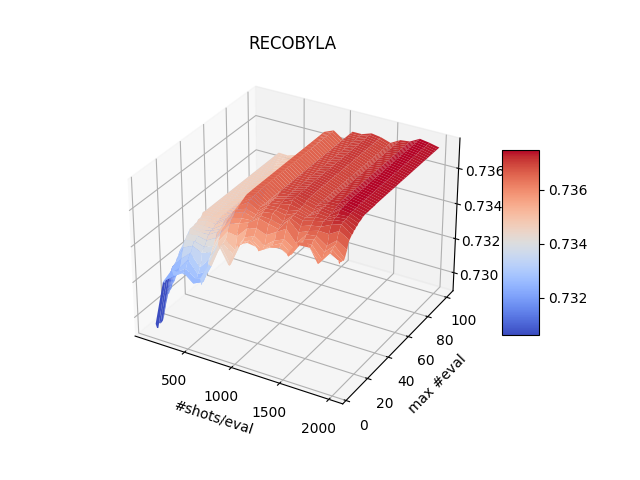

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x, y = np.meshgrid(shots_pool, maxfev_pool, indexing='ij')
zs = np.max(mean_ar.reshape(len(method_pool), len(shots_pool), -1, len(maxfev_pool)), axis=2)
for z, label in zip(zs, method_pool):
    if label == "RECOBYLA":
        surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        ax.set_title(label)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('#shots/eval')
ax.set_ylabel('max #eval')
ax.set_zlabel('mean ar')

In [ ]:
plt.figure()
# ys = np.max(mean_ar.reshape(1, -1, len(xtol_pool), axis=2)
ys = mean_ar.reshape(len(method_pool), len(shots_pool), len(rhobeg_pool), len(xtol_pool), len(maxfev_pool))
for y, label in zip(ys, method_pool):
    plt.plot(budget // np.array(maxfev_pool), y, label=f"{label}")
# plt.xlabel("Max function evaluations")
plt.xlabel("#Shots/evaluation")
plt.ylabel("Mean approximation ratio")
# plt.ylim(0.71, 0.74)
# plt.xlim(0, 40)
plt.axhline(np.mean(grid_best_ar), label="Grid best AR", color='r')
plt.axhline(np.mean(initial_point_ar), label="Initial point AR", color='g')
plt.legend()

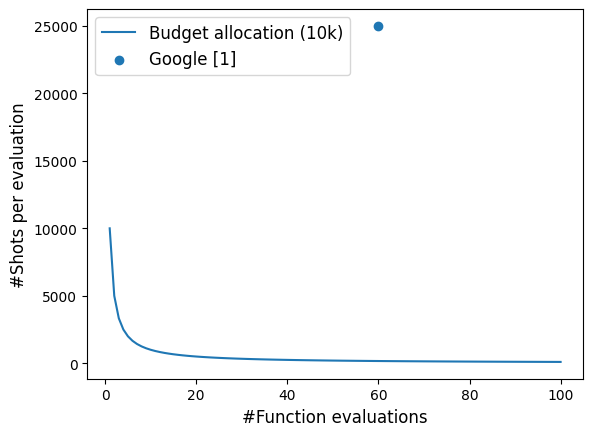

In [ ]:
plt.figure()
fontsize = 12
x = np.linspace(1, 100, 100)
plt.plot(x, 10000 / x, label="Budget allocation (10k)")
plt.xlabel("#Function evaluations", fontsize=fontsize)
plt.ylabel("#Shots per evaluation", fontsize=fontsize)
plt.scatter(60, 25000, label="Google [1]")
plt.legend(fontsize=fontsize)

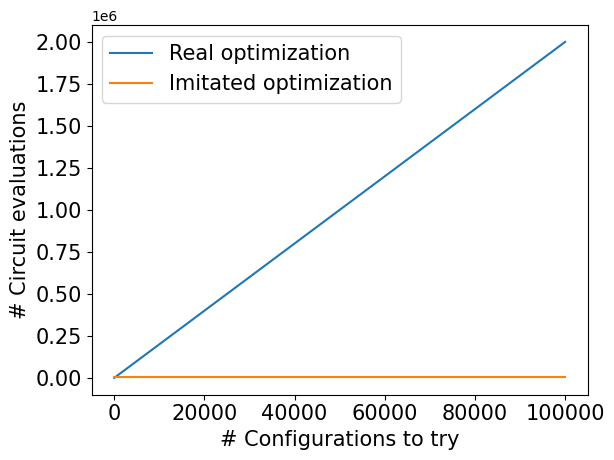

In [ ]:
x = np.linspace(0, 100000, 100)
fontsize = 15
plt.figure()
plt.plot(x, 20 * x, label="Real optimization")
plt.plot(x, np.array([2**12] * len(x)), label="Imitated optimization")
plt.xlabel("# Configurations to try", fontsize=fontsize)
plt.ylabel("# Circuit evaluations", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)